# Риск остеопороза у женщин
Для 500 участниц исследования Global Longitudinal Study of Osteoporosis in Women (Center for Outcomes Research, the University of Massachusetts/Worcester) измерены следующие показатели:

* возраст, лет (не меньше 55);
* вес, кг;
* рост, см;
* ИМТ, кг/см2;
* бинарные признаки: курение, индикатор наступления менопаузы до 45 лет, индикатор необходимости помощи при подъёме из сидячего положения, перелом шейки бедра в прошлом (был/не было), перелом шейки бедра у матери (был/не было);
* самостоятельная субъективная оценка вероятности перелома (меньше/такая же/больше, чем у сверстниц).

Известно, у кого из участниц в первый год исследования произошёл перелом шейки бедра. Необходимо построить модель вероятности перелома с учётом имеющихся признаков.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sns

In [2]:
data = pd.read_csv('./GLOW500.txt', delimiter='\t')
data.head()

,PRIORFRAC,AGE,WEIGHT,HEIGHT,BMI,PREMENO,MOMFRAC,ARMASSIST,SMOKE,RATERISK,FRACTURE
0,no,62,70.3,158,28.16055,no,no,no,no,same,no
1,no,65,87.1,160,34.02344,no,no,no,no,same,no
2,yes,88,50.8,157,20.60936,no,yes,yes,no,less,no
3,no,82,62.1,160,24.25781,no,no,no,no,less,no
4,no,61,68.0,152,29.43213,no,no,no,no,same,no


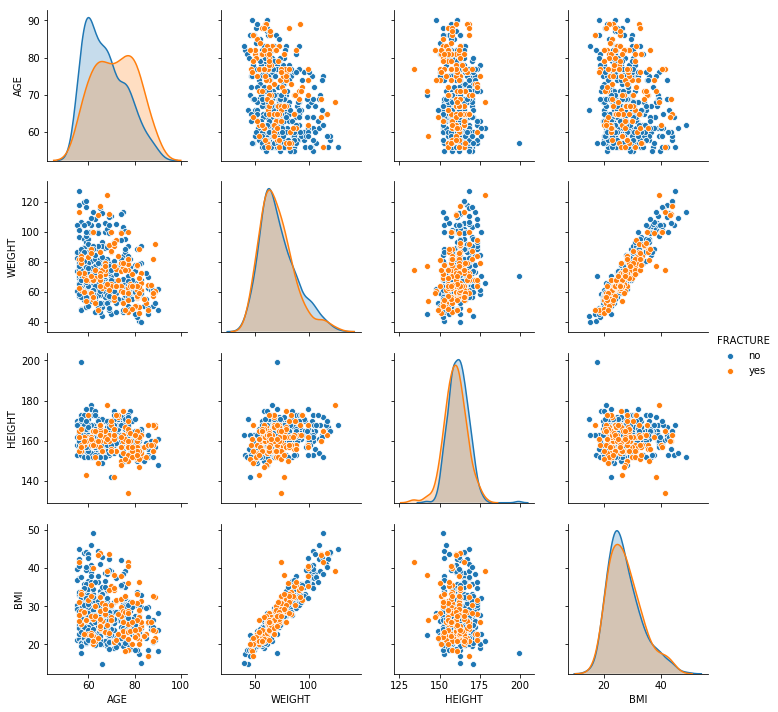

In [3]:
sns.pairplot(data, hue='FRACTURE')

Проверим разделимость классов по категориальным предикторам:

In [4]:
predictors = ['SMOKE', 'PREMENO', 'ARMASSIST', 'PRIORFRAC', 'RATERISK']
for k in predictors:
    print (data.groupby([k, 'FRACTURE']).size(),'\n\n')
    


SMOKE  FRACTURE
no     no          347
       yes         118
yes    no           28
       yes           7
dtype: int64 


PREMENO  FRACTURE
no       no          303
         yes         100
yes      no           72
         yes          25
dtype: int64 


ARMASSIST  FRACTURE
no         no          250
           yes          62
yes        no          125
           yes          63
dtype: int64 


PRIORFRAC  FRACTURE
no         no          301
           yes          73
yes        no           74
           yes          52
dtype: int64 


RATERISK  FRACTURE
greater   no           98
          yes          49
less      no          139
          yes          28
same      no          138
          yes          48
dtype: int64 




Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [5]:
import statsmodels.api as sm
predictors = list(data.columns)
predictors.remove('FRACTURE')

for p in predictors:
    model = sm.GLM.from_formula('FRACTURE~'+str(p), data=data, family=sm.families.Binomial()).fit()
    print (model.summary2())

                       Results: Generalized linear model
Model:              GLM                               AIC:            544.0679  
Link Function:      logit                             BIC:            -2554.8069
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -270.03   
Date:               2019-03-31 13:34                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       540.07    
Df Model:           1                                 Pearson chi2:   500.      
Df Residuals:       498                               Scale:          1.0000    
Method:             IRLS                                                        
-----------------------------------------------------------------------------------
                      Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept             1.4167      0.1305   

                       Results: Generalized linear model
Model:              GLM                               AIC:            556.5783  
Link Function:      logit                             BIC:            -2538.0819
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -275.29   
Date:               2019-03-31 13:34                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       550.58    
Df Model:           2                                 Pearson chi2:   500.      
Df Residuals:       497                               Scale:          1.0000    
Method:             IRLS                                                        
-----------------------------------------------------------------------------------
                        Coef.     Std.Err.      z       P>|z|      [0.025    0.975]
-----------------------------------------------------------------------------------
Intercept               0.6931      0.1750 

Многомерная модель со всеми значимыми предикторами:

In [6]:
model = sm.GLM.from_formula('FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISK',
                            data=data, family=sm.families.Binomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            523.5004  
Link Function:      logit                             BIC:            -2550.0868
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -253.75   
Date:               2019-03-31 13:35                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       507.50    
Df Model:           7                                 Pearson chi2:   486.      
Df Residuals:       492                               Scale:          1.0000    
Method:             IRLS                                                        
-----------------------------------------------------------------------------------
                      Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept            -3.4163      3.2068    -1.0653    0.2867    -9.7015     2.8690
PRIORFRAC[T.yes]     -0.6453      0.2461    -2.6224    0.0087    -1.1275    -0.1630
MOMFRAC[T.yes]       -0.6212      0.3070    -2.0237    0.0430    -1.2229    -0.0196
ARMASSIST[T.yes]     -0.4458      0.2328    -1.9148    0.0555    -0.9021     0.0105
RATERISK[T.less]      0.7069      0.2934     2.4092    0.0160     0.1318     1.2820
RATERISK[T.same]      0.2849      0.2611     1.0913    0.2751    -0.2268     0.7966
AGE                  -0.0343      0.0130    -2.6324    0.0085    -0.0599    -0.0088
HEIGHT                0.0438      0.0183     2.3999    0.0164     0.0080     0.0796
================================================================================

"""

Критерий Вальда считает модель существенно лучше константы:

In [7]:
model.wald_test('AGE=HEIGHT=PRIORFRAC[T.yes]=MOMFRAC[T.yes]=ARMASSIST[T.yes]=RATERISK[T.less]=RATERISK[T.same]=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[48.4671231]], p-value=2.8851048436498994e-08, df_denom=7>

Попробуем полностью или частично удалить RATERISK


In [8]:
model.wald_test('RATERISK[T.less]=RATERISK[T.same]=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[5.81992865]], p-value=0.054477673231125165, df_denom=2>

In [9]:
model.wald_test('RATERISK[T.less]=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[5.80438566]], p-value=0.01598625198426459, df_denom=1>

Оставим в модели RATERISKless — модель с ним значимо лучше, чем без него.

Попробуем возвращать в модель удалённые признаки, применяя критерий отношения правдоподобия и вычисляя Δβ̂ %:



In [10]:
def RATERISKless(x):
    return (x=='less')

model = sm.GLM.from_formula('FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST +  RATERISKless(RATERISK)',
                            data=data, family=sm.families.Binomial()).fit()
model.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            522.6898  
Link Function:      logit                             BIC:            -2555.1120
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -254.34   
Date:               2019-03-31 13:35                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       508.69    
Df Model:           6                                 Pearson chi2:   488.      
Df Residuals:       493                               Scale:          1.0000    
Method:             IRLS                                                        
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                        -3.2251   3.2112 -1.0043 0.3152 -9.5190  3.0688
PRIORFRAC[T.yes]                 -0.6858   0.2428 -2.8249 0.0047 -1.1616 -0.2100
MOMFRAC[T.yes]                   -0.6393   0.3058 -2.0907 0.0366 -1.2385 -0.0400
ARMASSIST[T.yes]                 -0.4642   0.2317 -2.0033 0.0451 -0.9183 -0.0100
RATERISKless(RATERISK)[T.True]    0.5438   0.2542  2.1393 0.0324  0.0456  1.0420
AGE                              -0.0329   0.0130 -2.5371 0.0112 -0.0583 -0.0075
HEIGHT                            0.0431   0.0183  2.3577 0.0184  0.0073  0.0790
================================================================================

"""

In [11]:
print ('ORIGINAL', (model.llf))
formula = 'FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)'
predictors2 = ['PRIORFRAC','WEIGHT', 'BMI', 'PREMENO', 'SMOKE']
for f in predictors2:
    formula2 =formula +'+'+f
    model2 = sm.GLM.from_formula(formula2,
                            data=data, family=sm.families.Binomial()).fit()
    print (f, model2.llf)

ORIGINAL -254.34490308054845
PRIORFRAC -254.34490308054845
WEIGHT -254.16550144631327
BMI -254.0708150176476
PREMENO -254.27057928005064
SMOKE -254.05697538025933


Проверим линейность логита по непрерывным признакам. Сглаженные диаграммы рассеяния: 

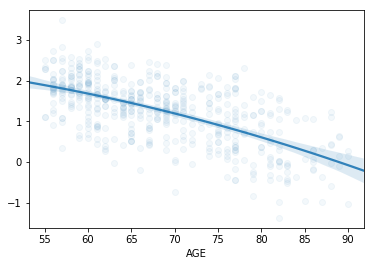

In [12]:
probs = model.predict(data)
odds = probs/(1-probs)
sns.regplot(data['AGE'], np.log(odds), order=2, scatter=True,scatter_kws={'alpha':0.05},line_kws={'alpha':0.9})

Попробуем добавить к модели признак AGE ≥ 80:



In [13]:
model2 = sm.GLM.from_formula('FRACTURE ~ AGE + AGE>=80 + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)',
                            data=data, family=sm.families.Binomial()).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            524.6797  
Link Function:      logit                             BIC:            -2548.9075
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -254.34   
Date:               2019-03-31 13:35                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       508.68    
Df Model:           7                                 Pearson chi2:   488.      
Df Residuals:       492                               Scale:          1.0000    
Method:             IRLS                                                        
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                        -3.1775   3.2457 -0.9790 0.3276 -9.5389  3.1839
AGE >= 80[T.True]                 0.0406   0.4041  0.1005 0.9200 -0.7513  0.8325
PRIORFRAC[T.yes]                 -0.6861   0.2427 -2.8265 0.0047 -1.1619 -0.2103
MOMFRAC[T.yes]                   -0.6393   0.3057 -2.0910 0.0365 -1.2385 -0.0401
ARMASSIST[T.yes]                 -0.4639   0.2317 -2.0021 0.0453 -0.9180 -0.0098
RATERISKless(RATERISK)[T.True]    0.5446   0.2543  2.1415 0.0322  0.0462  1.0430
AGE                              -0.0341   0.0179 -1.9049 0.0568 -0.0692  0.0010
HEIGHT                            0.0433   0.0184  2.3548 0.0185  0.0073  0.0794
================================================================================

"""

Ничего лучше линейной модели подобрать не удалось.

Рассмотрим теперь все модели, в которые добавлено одно межфакторное взаимодействие:

In [14]:
formula = 'FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)'
predictors = list(data.columns)
predictors.remove('FRACTURE')
for f1 in predictors:
    for f2 in predictors:
        formula2 =formula +'+{0}*{1}'.format(f1,f2)
        model2 = sm.GLM.from_formula(formula2,
                                data=data, family=sm.families.Binomial()).fit()
        for name, p in model2.pvalues.items():
            if p<0.05 and ':' in name:
                print (name,p)


PRIORFRAC[T.yes]:AGE 0.02308889195072482
PRIORFRAC[T.yes]:WEIGHT 0.027591624174045967
PRIORFRAC[T.yes]:BMI 0.023294339703387592
AGE:PRIORFRAC[T.yes] 0.02308889195072482
WEIGHT:PRIORFRAC[T.yes] 0.027591624174045967
HEIGHT:SMOKE[T.yes] 0.03813266575066089
BMI:PRIORFRAC[T.yes] 0.023294339703387592
MOMFRAC[T.yes]:ARMASSIST[T.yes] 0.03352507359760249
ARMASSIST[T.yes]:MOMFRAC[T.yes] 0.03352507359760249
SMOKE[T.yes]:HEIGHT 0.03813266575066089


Добавим все три межфакторных взаимодействия с p-value на уровне 0.025:

In [15]:
model3 = sm.GLM.from_formula("""FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC +   ARMASSIST + RATERISKless(RATERISK) +
                             +PRIORFRAC:AGE + PRIORFRAC:BMI + AGE:PRIORFRAC +  BMI:PRIORFRAC""",
                             data=data,  family=sm.families.Binomial()).fit()
model3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            520.1895  
Link Function:      logit                             BIC:            -2544.9685
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -250.09   
Date:               2019-03-31 13:35                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       500.19    
Df Model:           9                                 Pearson chi2:   492.      
Df Residuals:       490                               Scale:          1.0000    
Method:             IRLS                                                        
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                        -2.0476   3.6566 -0.5600 0.5755 -9.2144  5.1192
PRIORFRAC[T.yes]                 -1.9837   2.5483 -0.7784 0.4363 -6.9783  3.0109
MOMFRAC[T.yes]                   -0.7124   0.3097 -2.3007 0.0214 -1.3194 -0.1055
ARMASSIST[T.yes]                 -0.3933   0.2531 -1.5541 0.1202 -0.8894  0.1027
RATERISKless(RATERISK)[T.True]    0.5601   0.2581  2.1702 0.0300  0.0543  1.0659
AGE                              -0.0539   0.0174 -3.1064 0.0019 -0.0879 -0.0199
PRIORFRAC[T.yes]:AGE              0.0445   0.0273  1.6299 0.1031 -0.0090  0.0979
HEIGHT                            0.0429   0.0186  2.3096 0.0209  0.0065  0.0794
PRIORFRAC[no]:BMI                 0.0105   0.0259  0.4041 0.6861 -0.0402  0.0611
PRIORFRAC[yes]:BMI               -0.0577   0.0334 -1.7309 0.0835 -0.1231  0.0076
================================================================================

"""

Получается значимо лучше.

Посмотрим графики качества классификации: 

In [17]:
tp, tn = [],[]
fp, fn = [], []
labels = (data['FRACTURE']=='no')*1.0
probas = model3.predict(data)
thresholds = np.arange(0,1.0,0.05)
for t in thresholds:
    tp_ = (probas[labels==1]>=t)
    tn_ = (probas[labels==0]<t)
    fp_ = (probas[labels==0]>=t)
    fn_ = (probas[labels==1]<t)
    
    tp.append(tp_)
    tn.append(tn_)
    fp.append(fp_)
    fn.append(fn_)

0.7169173333333332 0.764


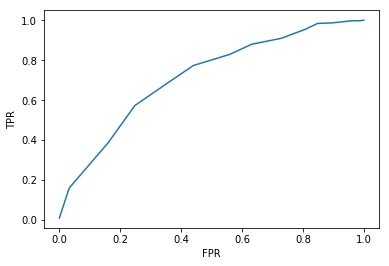

In [18]:
from sklearn.metrics import  auc,  accuracy_score

plt.plot(list(map(np.mean, fp)), list(map(np.mean, tp)))
plt.xlabel('FPR')
plt.ylabel('TPR')
print (auc(list(map(np.mean, fp)), list(map(np.mean, tp))),  accuracy_score(labels,probas>0.5))


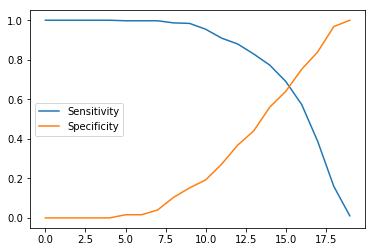

In [19]:
plt.plot(list(map(np.mean, tp)),  label='Sensitivity')
plt.plot(list(map(np.mean, tn)), label='Specificity')
plt.legend(loc='best')

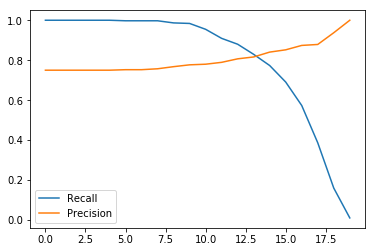

In [34]:
plt.plot(list(map(np.mean, tp)), label='Recall')

prec = [tp_.sum()/(tp_.sum()+fp_.sum()) for tp_, fp_ in zip(tp, fp)]
plt.plot(prec, label='Precision')

plt.legend(loc='best')


При пороге 0.6 построенная модель обеспечивает чувствительность 0.688 и специфичность 0.6933333; площадь под ROC-кривой составляет 0.72.

Модель позволяет сделать следующие выводы:

* для женщин, с которыми уже случался перелом шейки бедра, риск нового перелома в течение года существенно выше (в 109.28 раз, 95% доверительный интервал (2.75, 4402.65));
* каждые десять лет относительный риск перелома шейки бедра у женщин, с которыми он ещё не происходил, возрастает в 1.78 раз (1.29, 2.48); при этом для женщин, у которых уже был перелом, увеличение возраста не приносит дополнительного значимого увеличения риска перелома (мультипликативный прирост риска за 10 лет 1.01, 95% доверительный интервал 0.44, 2.35);
* при прочих равных для женщин маленького роста риск перелома выше — на каждые 10 сантиметров уменьшения роста приходится увеличение риска перелома в 1.54 раз (1.08, 2.23);
* для женщин, у матерей которых не было перелома шейки бедра, неспособность самостоятельно вставать из сидячего положения связана с повышением риска перелома в 1.88 раз (1.15, 3.09);
* для женщин, которые способны самостоятельно вставать из сидячего положения, наличие перелома у матери связано с повышением риска перелома в 3.37 раз (1.54, 7.27);
* женщины, оценивающие вероятность своего перелома как низкую, действительно при прочих равных имеют шанс перелома ниже в 1.74 раз (1.06, 2.91).

**Global Longitudinal Study of Osteoporosis in Women (выборка по Hosmer D.W., Lemeshow S., Sturdivant R.X. Applied logistic regression. — Hoboken: John Wiley & Sons, 2013, 1.6.3.)**